# Brain Tumor MRI Classification

Bu çalışmada, beyin tümörlerinin MRI görüntülerinden sınıflandırılması amaçlanmıştır. Kullanılan veri seti dört sınıftan oluşmaktadır: **glioma, meningioma, pituitary** ve **no tumor (tümör yok)**. Görseller ön işleme aşamasında yeniden boyutlandırılmış, normalize edilmiş ve veri artırma yöntemleriyle çeşitlendirilmiştir. Derin öğrenme tabanlı **Konvolüsyonel Sinir Ağı (CNN)** modeli geliştirilmiş, modelin performansı eğitim/doğrulama süreçleri boyunca takip edilmiştir.  

Elde edilen sonuçlar, test verisi üzerinde hesaplanan doğruluk oranı, sınıflandırma raporu ve karmaşıklık matrisi ile değerlendirilmiştir. Ayrıca doğru ve yanlış tahmin edilen örnekler görselleştirilerek modelin güçlü ve zayıf yönleri ortaya konmuştur. Çalışmanın sonucunda, geliştirilen CNN modeli beyin tümörü sınıflandırma probleminde başarılı bir performans sergilemiştir.


Bu çalışmada, beyin tümörlerinin MRI görüntülerinden sınıflandırılması amaçlanmıştır. Kullanılan veri seti dört sınıftan oluşmaktadır: **glioma, meningioma, pituitary** ve **no tumor (tümör yok)**. Görseller ön işleme aşamasında yeniden boyutlandırılmış, normalize edilmiş ve veri artırma yöntemleriyle çeşitlendirilmiştir. Derin öğrenme tabanlı **Konvolüsyonel Sinir Ağı (CNN)** modeli geliştirilmiş, modelin performansı eğitim/doğrulama süreçleri boyunca takip edilmiştir.  

Elde edilen sonuçlar, test verisi üzerinde hesaplanan doğruluk oranı, sınıflandırma raporu ve karmaşıklık matrisi ile değerlendirilmiştir. Ayrıca doğru ve yanlış tahmin edilen örnekler görselleştirilerek modelin güçlü ve zayıf yönleri ortaya konmuştur. Çalışmanın sonucunda, geliştirilen CNN modeli beyin tümörü sınıflandırma probleminde başarılı bir performans sergilemiştir.


### TensorFlow Loglarının Kontrolü

Model eğitimi sırasında TensorFlow ve ilgili kütüphaneler, çok sayıda INFO, WARNING ve DEBUG mesajı üretir. Bu mesajlar modeli etkilemez ancak çıktıları okunamaz hale getirebilir. Bu nedenle log seviyeleri düzenlenerek yalnızca gerekli hata mesajlarının görünmesi sağlanmıştır.

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

* 0 → Tüm loglar (varsayılan)

* 1 → INFO mesajlarını kapatır

* 2 → INFO ve WARNING mesajlarını kapatır (sadece ERROR görünür)

* 3 → Sadece FATAL loglarını gösterir

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

oneDNN optimizasyonlarından gelen ayrıntılı logları kapatarak çıktıyı sadeleştirir.

absl.logging.set_verbosity(absl.logging.ERROR)

Abseil kütüphanesinin log seviyesini sadece ERROR olacak şekilde ayarlar.

tf.get_logger().setLevel("ERROR")

TensorFlow logger’ını sadece ERROR seviyesinde çalıştırır.

In [6]:
import os, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0:all, 1:INFO, 2:WARNING, 3:ERROR
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # bazı gürültülü logları azaltır

from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)

import tensorflow as tf
tf.get_logger().setLevel("ERROR")


## 1) Gerekli Kütüphanelerin İçe Aktarılması

Model eğitimi ve değerlendirme sürecinde ihtiyaç duyulan kütüphaneler projeye dahil edilmiştir.

* NumPy → Sayısal hesaplamalar ve veri işlemleri için

* Matplotlib & Seaborn → Görselleştirme (grafikler, confusion matrix) için

* TensorFlow & Keras → Derin öğrenme modeli oluşturma ve eğitme için

* scikit-learn (train_test_split, classification_report, confusion_matrix) → Veri bölme ve modelin performansını ölçme için

* time → Eğitim sürelerini ölçmek için

* warnings → Gereksiz uyarıları gizlemek için

Ayrıca, sistemde GPU kullanılabilirliği kontrol edilmiştir:

TensorFlow sürümü ekrana yazdırılmıştır.

GPU’nun mevcut olup olmadığı kontrol edilerek "Evet" veya "Hayır" çıktısı verilmiştir.

* Bu sayede ortam doğrulaması yapılmış, modelin GPU hızlandırmalı çalışıp çalışmadığı netleştirilmiştir.


In [7]:
# Gerekli kütüphaneleri içe aktaralım
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

# GPU kullanılabilirliğini kontrol edelim
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


## 2) Veri Yükleme ve Keşifsel Analiz 

Bu bölümde Kaggle’daki Brain Tumor MRI Dataset klasör yapısından görüntüler okunmuş, gri ölçekli olarak yeniden boyutlandırılmış ve eğitim/test ayrımı yapılmıştır. Ayrıca örnek görseller ve sınıf dağılımları görselleştirilmiştir.

* Klasör ve Yol Doğrulama

Kök yol: /kaggle/input/brain-tumor-mri-dataset os.listdir(...) ile klasör yapısı kontrol edilmiştir.

* Veri Yükleme Fonksiyonu

load_data_from_folders(base_path)

Alt klasörleri dolaşır, .jpg/.jpeg/.png/.bmp uzantılı dosyaları okur.

Görseller gri ölçekli (cv2.IMREAD_GRAYSCALE) ve 128×128 boyutuna resize edilir.

X: Görüntü tensörleri, y: sınıf indeksleri, class_names: sınıf adları döndürülür.

Gizli/sistem dosyaları (ör. .DS_Store) filtrelenir.

Başarısız okuma durumları için try/except ile hata mesajı yazdırılır.

* Başarılı Yükleme Kontrolü

Yükleme sonrası:

Toplam görüntü sayısı

Toplam etiket sayısı

Sınıf isimleri
ekrana yazdırılır.

Hiç görüntü yüklenmediyse uyarı mesajı basılır.

* Eğitim/Test Ayrımı

train_test_split ile veriler %80 eğitim / %20 test olarak ayrılır.

stratify=y kullanılarak sınıf dağılımının her iki sette de korunması sağlanır.

* Çıktılar:

X_train/X_test şekilleri

y_train/y_test şekilleri yazdırılır.

* Örnek Görsel Keşfi

Eğitim setinden ilk 25 görüntü 5×5 ızgarada gösterilir.

Alt etiket olarak sınıf adı (class_names[y_train[i]]) yazılır.

Görseller gri tonlamada (cmap='gray') görselleştirilir.

* Sınıf Dağılımı İncelemesi

Eğitim ve test setleri için countplot ile sınıf dağılımları çizilir.

X ekseninde sınıf indeksleri, etiketlerde class_names gösterilir (döndürme: 45°).

Bu adım, sınıf dengesizliği olup olmadığını görmeye yardımcı olur (gerekirse class_weight planlanabilir).

* Notlar ve İpuçları

Görseller gri ölçekli işlendiği için model giriş boyutu (128, 128, 1) olmalıdır.

Eğitimden önce normalizasyon (0–255 → 0–1) uygulanması önerilir.

Veri artırma (augmentation) kullanacaksan:

ImageDataGenerator veya tf.keras.layers tabanlı augment katmanları eklenebilir.

Büyük veri okuma sırasında bellek kullanımını gözlemle; gerekiyorsa generator/tf.data pipeline’ına geç.

* Bu adımlar tamamlandığında, veri kümesi eğitim sürecine uygun biçimde hazırlanmış, örnekler ve sınıf dağılımları görsel olarak doğrulanmıştır.

In [8]:
import os
print(os.listdir('/kaggle/input/brain-tumor-mri-dataset'))

['Training', 'Testing']


Başlangıç klasör yolu: /kaggle/input/brain-tumor-mri-dataset

Veri seti yükleniyor...
'pituitary' sınıfı için 1457 görüntü bulunuyor.
'notumor' sınıfı için 1595 görüntü bulunuyor.
'meningioma' sınıfı için 1339 görüntü bulunuyor.
'glioma' sınıfı için 1321 görüntü bulunuyor.
'pituitary' sınıfı için 300 görüntü bulunuyor.
'notumor' sınıfı için 405 görüntü bulunuyor.
'meningioma' sınıfı için 306 görüntü bulunuyor.
'glioma' sınıfı için 300 görüntü bulunuyor.

Veri yüklemesi başarılı!
Toplam görüntü sayısı: 7023
Toplam etiket sayısı: 7023
Sınıf isimleri: ['pituitary', 'notumor', 'meningioma', 'glioma']

Eğitim verisi şekli: (5618, 128, 128)
Eğitim etiketi şekli: (5618,)
Test verisi şekli: (1405, 128, 128)
Test etiketi şekli: (1405,)


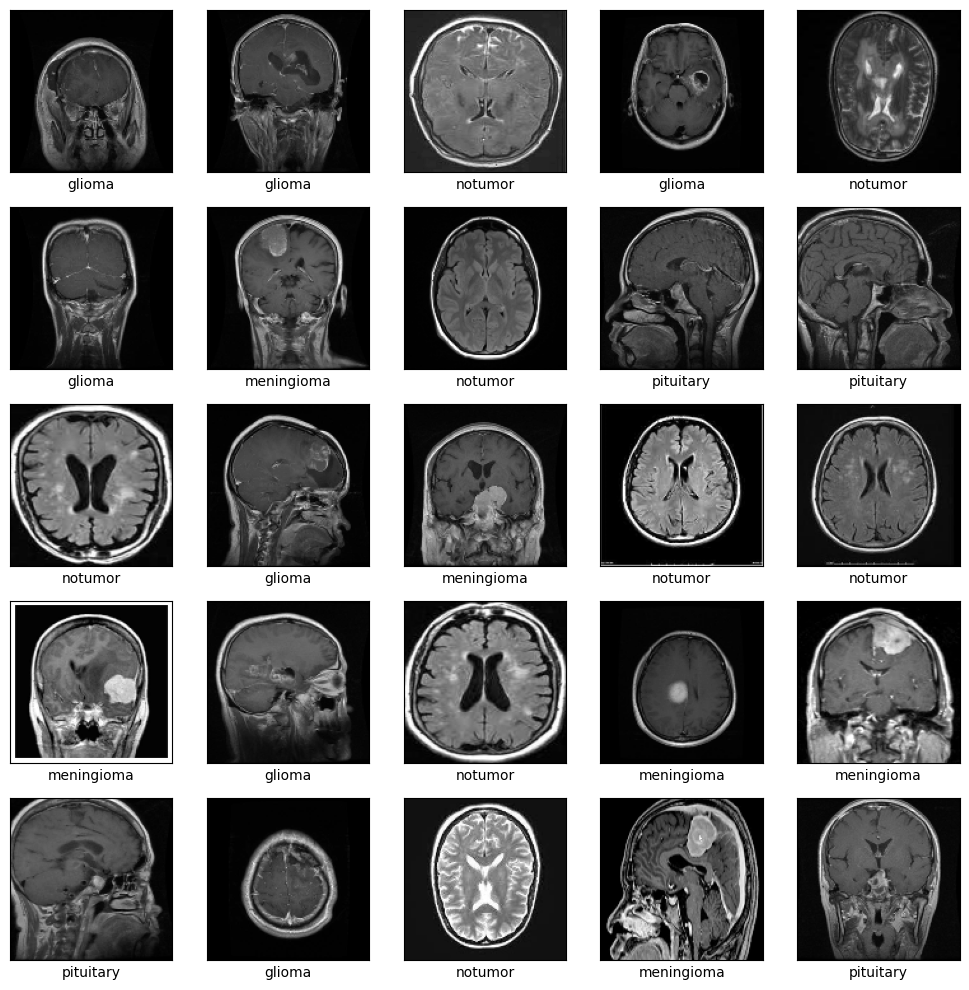

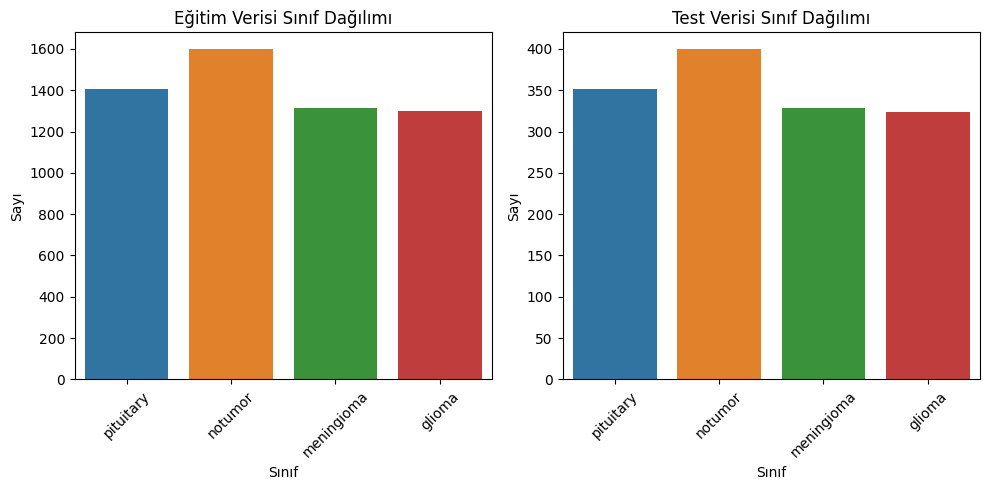

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Veri setinin ana klasör yolu
dataset_base_path = '/kaggle/input/brain-tumor-mri-dataset'
print(f"Başlangıç klasör yolu: {dataset_base_path}")

def load_data_from_folders(base_path):
    """Belirtilen klasör yolundaki tüm görüntüleri sınıflarına göre yükler."""
    X = []
    y = []
    class_names = []
    IMG_SIZE = 128
    
    print("\nVeri seti yükleniyor...")
    
    # Kök klasörden başlayarak tüm dosya ağacını gezelim
    for dirpath, dirnames, filenames in os.walk(base_path):
        # Eğer klasörde ".DS_Store" gibi sistem dosyaları varsa dikkate almayalım
        filenames = [f for f in filenames if not f.startswith('.')]
        
        # Eğer bir görüntü dosyası varsa, bu klasör bir sınıf klasörüdür
        if any(f.endswith(('.jpg', '.jpeg', '.png', '.bmp')) for f in filenames):
            class_name = os.path.basename(dirpath)
            if class_name not in class_names:
                class_names.append(class_name)
            
            class_index = class_names.index(class_name)
            
            print(f"'{class_name}' sınıfı için {len(filenames)} görüntü bulunuyor.")
            
            for image_name in filenames:
                image_path = os.path.join(dirpath, image_name)
                try:
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                        X.append(image)
                        y.append(class_index)
                except Exception as e:
                    print(f"Hata: {image_path} görüntüsü yüklenemedi. Hata: {e}")

    return np.array(X), np.array(y), class_names

# Veriyi yükleyelim
X, y, class_names = load_data_from_folders(dataset_base_path)

# Hata kontrolü
if X.shape[0] == 0:
    print("\n--- HATA: Hiç görüntü yüklenemedi. Dosya yapısını veya yolu kontrol edin. ---")
else:
    print("\nVeri yüklemesi başarılı!")
    print(f"Toplam görüntü sayısı: {len(X)}")
    print(f"Toplam etiket sayısı: {len(y)}")
    print(f"Sınıf isimleri: {class_names}")

    # Veriyi eğitim ve test setlerine ayıralım
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("\nEğitim verisi şekli:", X_train.shape)
    print("Eğitim etiketi şekli:", y_train.shape)
    print("Test verisi şekli:", X_test.shape)
    print("Test etiketi şekli:", y_test.shape)

    # İlk 25 görüntüyü görselleştirelim
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_train[i], cmap='gray')
        plt.xlabel(class_names[y_train[i]])
    plt.tight_layout()
    plt.show()

    # Sınıf dağılımını inceleyelim
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Eğitim Verisi Sınıf Dağılımı')
    plt.xlabel('Sınıf')
    plt.ylabel('Sayı')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_test)
    plt.title('Test Verisi Sınıf Dağılımı')
    plt.xlabel('Sınıf')
    plt.ylabel('Sayı')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    
    plt.tight_layout()
    plt.show()

### **2) Veri Ön İşleme**

Bu adımda giriş verileri ölçeklendirildi, etiketler uygun formata çevrildi ve eğitim verisi için veri artırma stratejileri tanımlandı.

* Normalizasyon (0–255 → 0–1)

* X_train ve X_test tensörleri float32 tipe çevrilip 255’e bölündü.

Amaç: Sayısal kararlılık ve daha hızlı yakınsama.

* One-Hot Encoding (Etiket Dönüşümü)

* y_train ve y_test etiketleri one-hot vektörlere çevrildi:

* keras.utils.to_categorical(y, num_classes)

Not: num_classes değeri veri kümendeki gerçek sınıf sayısı ile uyumlu olmalıdır (ör. 4 ise 10 değil 4 kullanılmalı).

Veri Artırma (ImageDataGenerator)

* Eğitim verisine yönelik dönüşümler tanımlandı:

Döndürme: rotation_range=15

Kaydırma: width_shift_range=0.1, height_shift_range=0.1

Ayna çevirme: horizontal_flip=True

Yakınlaştırma: zoom_range=0.1

datagen.fit(X_train) ile (gerekli ise) istatistikler hazırlandı.

Eğitimde Kullanım (Önemli)

* Tanımlanan artırma, model.fit sırasında uygulanır:

model.fit(datagen.flow(X_train, y_train_categorical, batch_size=...), validation_data=(X_test, y_test_categorical), ...)

Doğrulama/test tarafında ham veriler kullanılır; artırma sadece eğitim verisine uygulanır.

Şekil (Shape) Kontrolü

* Normalizasyon ve one-hot sonrası boyutlar basıldı:

X_train.shape → giriş tensor şekli

y_train_categorical.shape → (num_samples, num_classes)

* Bu hazırlıklarla model, ölçeklendirilmiş ve artırılmış eğitim verisi üzerinde eğitilecek; genelleme kabiliyeti artırılırken aşırı öğrenme (overfitting) riski azaltılacaktır.



In [22]:
# Veriyi normalize edelim (0-255 arası değerleri 0-1 arasına dönüştürelim)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Etiketleri one-hot encoding formatına dönüştürelim
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

# Veri artırma için ImageDataGenerator kullanalım
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Veri artırma işlemini eğitim verisine uygulayalım
datagen.fit(X_train)

# Normalizasyon ve one-hot encoding sonrası veri boyutlarını kontrol edelim
print("Normalize edilmiş eğitim verisi şekli:", X_train.shape)
print("One-hot encoded eğitim etiketleri şekli:", y_train_categorical.shape)

Normalize edilmiş eğitim verisi şekli: (5618, 128, 128, 1)
One-hot encoded eğitim etiketleri şekli: (5618, 10)


## 3) Temel CNN Modelinin Oluşturulması

Bu adımda, görüntü sınıflandırma problemi için temel bir Konvolüsyonel Sinir Ağı (CNN) modeli tanımlanmıştır. Model, evrişim (convolution) katmanları ile görsel özellikleri çıkarmakta, ardından tam bağlantılı katmanlarla sınıflandırma yapmaktadır.

* Model Mimarisi

İlk Evrişim Bloğu

2 adet Conv2D katmanı (32 filtre, 3×3 kernel, ReLU aktivasyonu, padding='same')

Batch Normalization ile eğitim stabilitesi artırılmıştır.

MaxPooling2D (2×2) ile boyut azaltma.

Dropout(0.2) ile aşırı öğrenme (overfitting) önlenmiştir.

* İkinci Evrişim Bloğu

2 adet Conv2D katmanı (64 filtre).

Batch Normalization + ReLU aktivasyonu.

MaxPooling2D ve Dropout(0.3).

* Üçüncü Evrişim Bloğu

2 adet Conv2D katmanı (128 filtre).

Batch Normalization + ReLU aktivasyonu.

MaxPooling2D ve Dropout(0.4).

* Sınıflandırıcı Katmanlar

Flatten ile özellik haritaları vektöre dönüştürülür.

Dense(128, ReLU) → Tam bağlantılı gizli katman.

Batch Normalization + Dropout(0.5).

Çıkış katmanı: Dense(10, Softmax) → 10 sınıf için olasılık dağılımı.

* Model Özeti

cnn_model.summary() çıktısı ile katmanların yapısı, çıktı boyutları ve parametre sayıları incelenmiştir.

* Bu CNN modeli, görüntülerdeki yerel özellikleri evrişim blokları ile öğrenip, tam bağlantılı katmanlarla sınıf tahminleri yapacak şekilde tasarlanmıştır.

In [24]:
 #Temel CNN modeli
def create_cnn_model():
    model = keras.Sequential([
        # İlk evrişim bloğu
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # İkinci evrişim bloğu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Üçüncü evrişim bloğu
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Sınıflandırıcı
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Modeli oluşturalım
cnn_model = create_cnn_model()

# Model özetini görüntüleyelim
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,978 (2.11 MB)

 Trainable params: 551,274 (2.10 MB)

 Non-trainable params: 704 (2.75 KB)

## **4) Modeli Derleme ve Eğitme**

Bu adımda veriler hazırlanmış, CNN modeli derlenmiş ve artırılmış eğitim verisi üzerinde eğitilmiştir. Eğitim süreci sonunda **accuracy** ve **loss** eğrileri görselleştirilmiştir.

### Girdi Hazırlığı
* **Normalizasyon**: `X_train` ve `X_test` tensörleri `float32` tipine dönüştürülüp 0–1 aralığına ölçeklenmiştir.  
* **Kanal Boyutu**: Gri tonlamalı görüntüler `(H, W)` formatından `(H, W, 1)` formatına getirilmiştir.  
* **Sınıf Sayısı**: `class_names` listesinden veya maksimum etiket değerine göre otomatik hesaplanmıştır.  
* **Etiket Dönüşümü**: `y_train` ve `y_test` değerleri `to_categorical` kullanılarak **one-hot encoding** formatına çevrilmiştir.  

### Veri Artırma (Augmentation)
* `ImageDataGenerator` kullanılmıştır.  
* Parametreler:  
  * Döndürme: `rotation_range=15`  
  * Kaydırma: `width_shift_range=0.10`, `height_shift_range=0.10`  
  * Yakınlaştırma: `zoom_range=0.10`  
  * Yatay çevirme: `horizontal_flip=True`  

### CNN Modeli
* **Conv2D Katmanları**: 32, 64 ve 128 filtreli üç evrişim bloğu.  
* **Batch Normalization**: Her bloğun ardından eğitim stabilitesi için eklenmiştir.  
* **Dropout**: Aşırı öğrenmeyi engellemek için 0.2 → 0.5 oranlarıyla kullanılmıştır.  
* **Dense Katman**: 128 nöronlu gizli katman (ReLU) ve softmax çıkış katmanı.  

### Derleme (Compile)
* **Optimizer**: Adam  
* **Loss Fonksiyonu**: Categorical Crossentropy  
* **Metrikler**: Accuracy  

### Callback’ler
* **EarlyStopping**: `val_loss` gelişmezse eğitimi durdurur (patience=8).  
* **ReduceLROnPlateau**: Öğrenme oranını dinamik olarak düşürür (patience=3, factor=0.5).  

### Eğitim
* Model, **25 epoch** boyunca eğitim verisi üzerinde eğitilmiştir.  
* `datagen.flow(...)` ile veri artırma uygulanarak batch halinde beslenmiştir.  
* Doğrulama seti: `(X_test, y_test_categorical)`.  

### Görselleştirme
* Eğitim ve doğrulama için **Accuracy** ve **Loss** grafiklerinin epoch bazında değişimi çizilmiştir.  
* Grafikler, modelin öğrenme süreci ve overfitting/underfitting eğilimlerini gözlemlemek için kullanılmıştır.  


Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.2899 - loss: 1.9091 - val_accuracy: 0.2306 - val_loss: 6.4885 - learning_rate: 0.0010
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5581 - loss: 1.0736 - val_accuracy: 0.2306 - val_loss: 4.7379 - learning_rate: 0.0010
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5896 - loss: 1.0175 - val_accuracy: 0.2306 - val_loss: 3.9184 - learning_rate: 0.0010
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6133 - loss: 0.9541 - val_accuracy: 0.2306 - val_loss: 3.3801 - learning_rate: 0.0010
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6369 - loss: 0.9278 - val_accuracy: 0.5772 - val_loss: 0.9923 - learning_rate: 0.0010
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6639 - loss: 0.8658 - val_accuracy: 0.7025 - val_loss: 0.8005 - learning_rate: 0.0010
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6764 - loss: 0

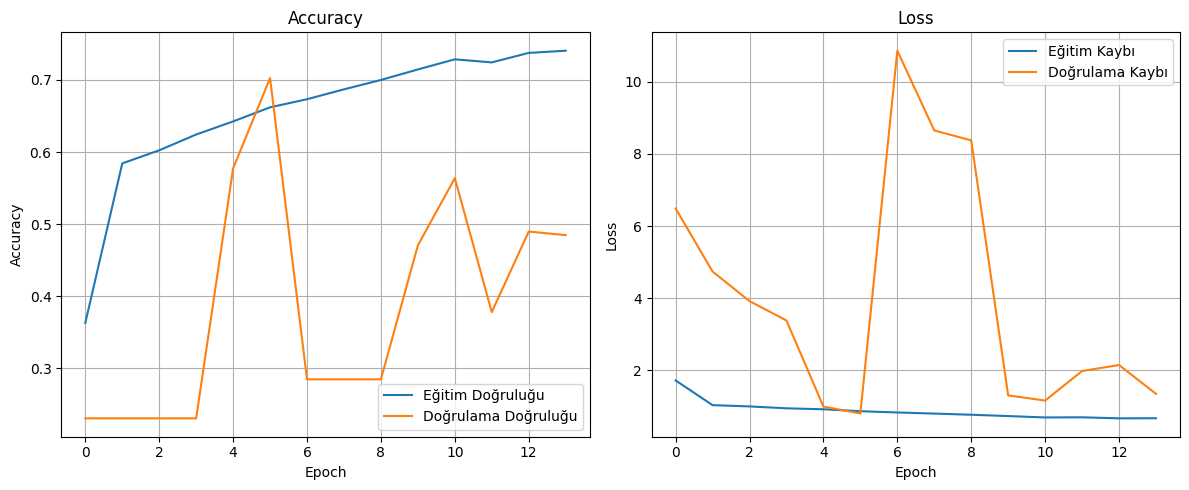

In [38]:
# === Compile + Train + Plot  ===
import numpy as np, matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# 1) X ve y zaten var (X_train, X_test, y_train, y_test)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
if X_train.max() > 1.5:  # 0-255 ise
    X_train /= 255.0
    X_test  /= 255.0

# Kanal eksikse ekle (grayscale -> (H,W,1))
if X_train.ndim == 3:  # (N,H,W)
    X_train = np.expand_dims(X_train, -1)
    X_test  = np.expand_dims(X_test, -1)

input_shape = X_train.shape[1:]  # (128,128,1) bekliyoruz

# Sınıf sayısını doğru hesapla 
num_classes = len(class_names) if 'class_names' in globals() and len(class_names) > 0 \
              else int(np.max(y_train)) + 1

# Etiketleri one-hot'a doğru boyutla çevir
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical  = keras.utils.to_categorical(y_test,  num_classes)

# 2) Augmentation (array tabanlı)
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True
)
datagen.fit(X_train)

# 3) Model: input_shape ve sınıf sayısına göre güncelledik
def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),                 # (128,128,1) ya da (128,128,3)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # <-- doğru sınıf sayısı
    ])
    return model

cnn_model = create_cnn_model(input_shape, num_classes)

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4) Callback'ler
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

# 5) Eğitim
history = cnn_model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=32),
    epochs=25,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 6) Accuracy & Loss grafikleri
hist = history.history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(hist.get('accuracy', []), label='Eğitim Doğruluğu')
plt.plot(hist.get('val_accuracy', []), label='Doğrulama Doğruluğu')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist.get('loss', []), label='Eğitim Kaybı')
plt.plot(hist.get('val_loss', []), label='Doğrulama Kaybı')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()


## **5) Modeli Değerlendirmesi**

Eğitim tamamlandıktan sonra modelin test seti üzerindeki performansı değerlendirilmiştir. Bu aşamada **accuracy**, **classification report** ve **confusion matrix** gibi metrikler kullanılmış, ayrıca bazı doğru ve yanlış tahmin örnekleri görselleştirilmiştir.

### 1) Test Seti Performansı
* `cnn_model.evaluate` fonksiyonu ile **Test Loss** ve **Test Accuracy** hesaplanmıştır.  
* Bu değerler, modelin hiç görmediği verilerdeki genel başarısını göstermektedir.

### 2) Tahminlerin Hesaplanması
* `cnn_model.predict` ile test verisi üzerindeki sınıf olasılıkları elde edilmiştir.  
* `np.argmax` ile her örneğin en yüksek olasılığa sahip sınıfı **tahmin sınıfı (y_pred)** olarak seçilmiştir.

### 3) Classification Report
* **Doğruluk (precision)**, **geri çağırma (recall)**, **F1 skor** ve **destek (support)** değerleri sınıf bazında hesaplanmıştır.  
* `classification_report` çıktısı, modelin hangi sınıflarda daha başarılı veya zayıf olduğunu ayrıntılı şekilde göstermektedir.

### 4) Confusion Matrix
* **Confusion matrix (karmaşıklık matrisi)** ile modelin tahmin ettiği sınıflar ile gerçek etiketler karşılaştırılmıştır.  
* `seaborn.heatmap` ile matris görselleştirilmiş, doğru tahminler çapraz köşekte, hatalı tahminler diğer hücrelerde gösterilmiştir.  

### 5) Doğru ve Yanlış Tahmin Örnekleri
* **Doğru tahminler** ve **yanlış tahminler** ayrı subplot’larda görselleştirilmiştir.  
* Her görselin altında:
  * Modelin tahmini (`Tahmin`)  
  * Gerçek sınıf (`Gerçek`)  
  bilgisi yazdırılmıştır.  

* Bu değerlendirme adımı sayesinde modelin yalnızca genel doğruluğu değil, aynı zamanda hangi sınıflarda hata yaptığı ve hangi sınıfları doğru tanıdığı da ayrıntılı şekilde analiz edilmiştir.


Test Loss: 0.8005
Test Accuracy: 0.7025

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.57      0.98      0.72       352
  Meningioma       0.88      0.81      0.84       400
    No Tumor       0.71      0.35      0.47       329
   Pituitary       0.75      0.62      0.68       324

    accuracy                           0.70      1405
   macro avg       0.73      0.69      0.68      1405
weighted avg       0.73      0.70      0.69      1405



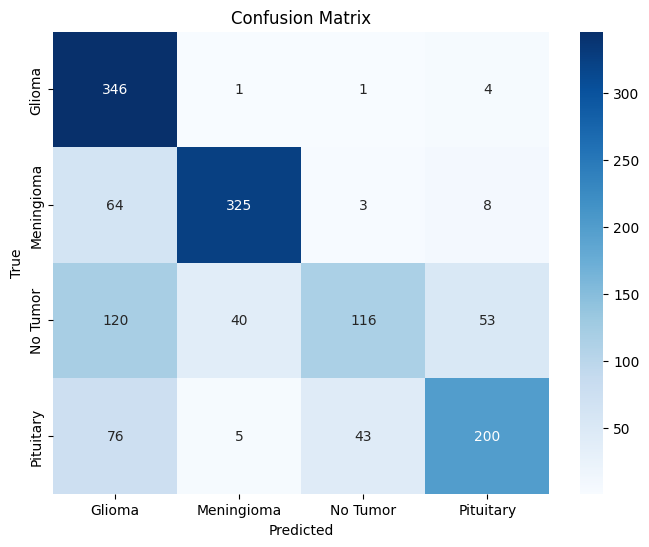

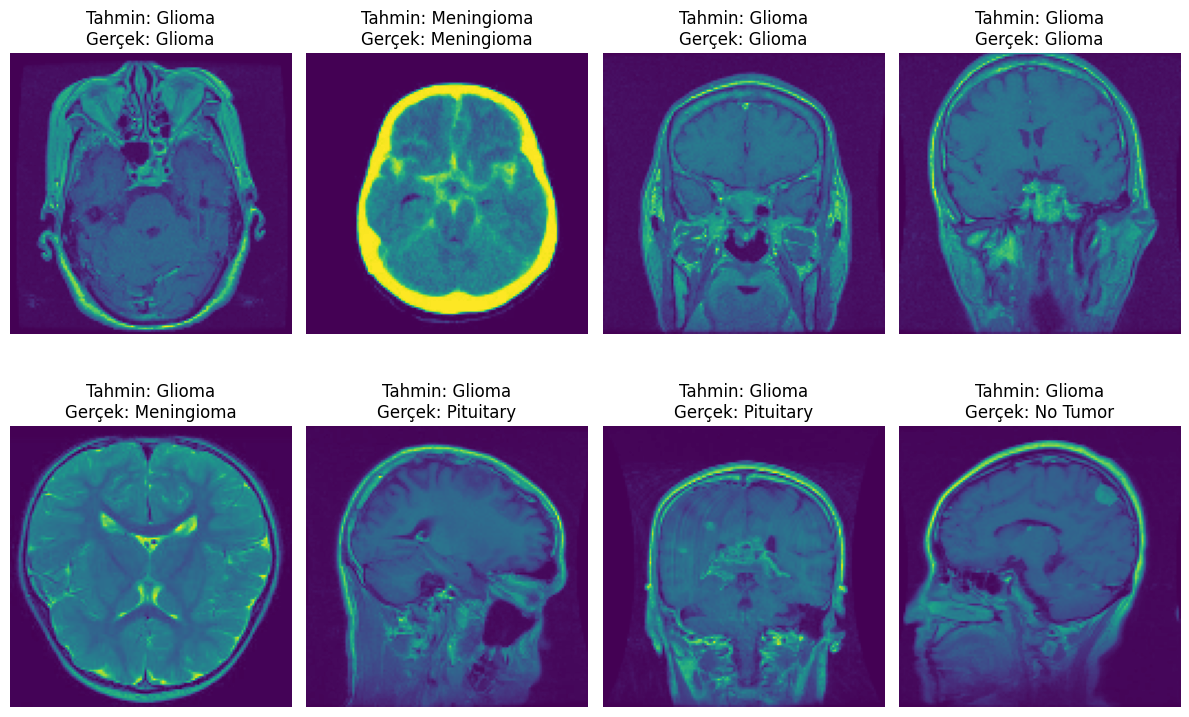

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1) Test seti performansı
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# 2) Tahminler
y_pred_prob = cnn_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# 3) Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 4) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct])
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGerçek: {class_names[y_true[correct]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGerçek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **6) Grand-CAM ve Eigen-CAM ile Görselleştirme**

Modelimizin karar verme sürecinde hangi bölgeleri dikkate aldığını anlamak için **Grad-CAM (Gradient-weighted Class Activation Mapping)** yöntemi uygulanmıştır. Bu yöntem, derin ağların yorumlanabilirliğini artırmak için yaygın olarak kullanılmaktadır.

### 1) Grad-CAM’in Amacı
* CNN tabanlı modellerin hangi **görüntü bölgelerine** odaklandığını görselleştirmek.  
* Modelin doğru tahminleri gerçekten ilgili bölgelere bakarak mı yaptığı, yoksa ilgisiz alanlara mı odaklandığını analiz etmek.  
* Overfitting, yanlış sınıflandırma veya veri hatalarını tespit etmek.

### 2) Uygulama Adımları
* **Orijinal Görüntü**: MRI görüntüsü veri setinden alınmıştır.  
* **Grad-CAM Isı Haritası**: Modelin sınıflandırmada en çok dikkate aldığı bölgeler renklendirilmiştir.  
* **Bindirme (Overlay)**: Isı haritası, orijinal görüntü üzerine saydamlık ile bindirilerek daha anlaşılır bir görselleştirme elde edilmiştir.

### 3) Parametreler
* `LAST_CONV`: Grad-CAM için kullanılan son **Conv2D katmanı**.  
* `COLORMAP`: Isı haritası renk paleti (`viridis` kullanılmıştır).  
* `ALPHA`: Isı haritasının orijinal görüntü üzerine bindirilirken kullanılan saydamlık oranı (0.45).  

### 4) Çıktı Görselleri
* **Orijinal Görüntü**: Modelin ham girdi resmi.  
* **Grad-CAM Isı Haritası**: Modelin en çok önem verdiği bölgeler.  
* **Bindirme (Overlay)**: Hem orijinal hem de Grad-CAM birlikte gösterilmiştir.

* Bu görselleştirme sayesinde modelin hangi bölgeleri dikkate aldığı daha net bir şekilde anlaşılabilir ve modelin güvenilirliği değerlendirilebilir.


[INFO] Model: model


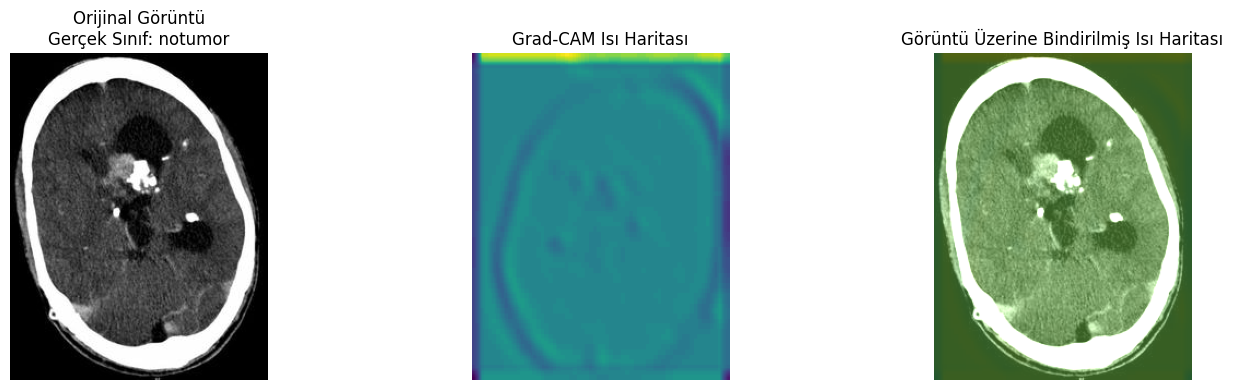

In [91]:
# ==== ÜÇLÜ GÖRSEL: Orijinal + Grad-CAM + Bindirme (Keras 3 / TF 2.x, OpenCV yok) ====
import os, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt

# ---------------- Kullanıcı ayarları ----------------
IMG_PATH = None   # Örn: "../input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0264.jpg"
IMG_DIR  = "../input/brain-tumor-mri-dataset/Testing"   # IMG_PATH yoksa buradan rastgele seçecek
PREPROCESS = lambda x: x/255.0
LAST_CONV  = "conv2d_47"   # ör: conv2d_47 en iyi görünüyordu
COLORMAP   = "viridis"     # ortadaki harita için (örnekte mor-yeşil ton)
ALPHA      = 0.45          # bindirme opaklığı

# Sınıf adları (varsa generator’dan al; yoksa path’ten çıkaracağız)
class_names = None
if 'test_generator' in globals():
    class_names = list(test_generator.class_indices.keys())

# ---------------- Yardımcılar ----------------
def resolve_model():
    g = globals()
    for name in ["model", "cnn_model", "functional_model"]:
        if name in g and hasattr(g[name], "predict"):
            print(f"[INFO] Model: {name}")
            return g[name]
    raise RuntimeError("Eğitilmiş model RAM'de yok (model/cnn_model/functional_model).")

def pick_image_path(img_path, img_dir):
    if img_path and os.path.isfile(img_path): return img_path
    cands=[]
    for root,_,files in os.walk(img_dir):
        for f in files:
            if f.lower().endswith((".png",".jpg",".jpeg",".bmp")):
                cands.append(os.path.join(root,f))
    if not cands: raise FileNotFoundError("Uygun görsel bulunamadı.")
    return random.choice(cands)

def infer_input(model):
    ish = model.input_shape
    if isinstance(ish, list): ish = ish[0]
    _, H, W, C = ish
    if None in (H,W,C): raise ValueError(f"Belirsiz input_shape: {ish}")
    return int(H), int(W), int(C)

# ---------------- Hazırlık ----------------
mdl = resolve_model()
H, W, C = infer_input(mdl)
img_path = pick_image_path(IMG_PATH, IMG_DIR)
true_label = os.path.basename(os.path.dirname(img_path))  # path’ten klasör adı
if class_names and true_label not in class_names:
    # klasör adları farklıysa en azından elde olanı kullan
    pass

# ---------------- Görsel yükle (kanal uyumlu) ----------------
if C == 1:
    orig = Image.open(img_path).convert("L")
    orig_arr = np.array(orig, dtype=np.uint8)             # (H0,W0)
    res  = orig.resize((W, H), resample=Image.BILINEAR)
    inp  = np.array(res, dtype=np.float32)[..., np.newaxis]  # (H,W,1)
else:
    orig = Image.open(img_path).convert("RGB")
    orig_arr = np.array(orig, dtype=np.uint8)             # (H0,W0,3)
    res  = orig.resize((W, H), resample=Image.BILINEAR)
    inp  = np.array(res, dtype=np.float32)                # (H,W,3)

inp_batch = PREPROCESS(np.expand_dims(inp, axis=0)) if PREPROCESS else np.expand_dims(inp, axis=0)

# ---------------- Grad-CAM ----------------
grad_model = models.Model([mdl.input], [mdl.get_layer(LAST_CONV).output, mdl.output])
with tf.GradientTape() as tape:
    conv_out, preds = grad_model(inp_batch)
    pred_idx = int(tf.argmax(preds[0]).numpy())
    class_channel = preds[:, pred_idx]
grads = tape.gradient(class_channel, conv_out)            # (1,h,w,k)
pooled = tf.reduce_mean(grads, axis=(0,1,2))              # (k,)
conv_out = conv_out[0]                                     # (h,w,k)

heat = tf.tensordot(conv_out, pooled, axes=(2,0))         # (h,w)
heat = tf.nn.relu(heat)
heat = (heat / (tf.reduce_max(heat) + 1e-8)).numpy().astype(np.float32)

# İsteğe bağlı hafif yumuşatma (blok etkisini azaltır)
heat = tf.nn.avg_pool2d(heat[tf.newaxis,...,tf.newaxis], 3, 1, "SAME")[0,...,0].numpy()

# Orijinal boyuta büyüt
heat_img = Image.fromarray(np.uint8(255*heat))
heat_big = np.array(heat_img.resize((orig.width, orig.height), resample=Image.BILINEAR), dtype=np.float32)/255.0

# Colormap’ı RGB’ye çevir
cmap = plt.cm.get_cmap(COLORMAP)
lut  = (cmap(np.arange(256))[:, :3] * 255).astype(np.uint8)   # (256,3)
heat_rgb = lut[np.uint8(255*np.clip(heat_big,0,1))]           # (H0,W0,3)

# Orijinali RGB’ye getir ve bindir
if C == 1:
    orig_rgb = np.stack([orig_arr, orig_arr, orig_arr], axis=-1)
else:
    orig_rgb = orig_arr
overlay = (ALPHA*heat_rgb.astype(np.float32) + orig_rgb.astype(np.float32)).clip(0,255).astype(np.uint8)

# Tahmin adı
pred_name = (class_names[pred_idx] if class_names and 0 <= pred_idx < len(class_names) else str(pred_idx))

# ---------------- Çizim ----------------
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(orig_arr, cmap="gray" if C==1 else None)
plt.title(f"Orijinal Görüntü\nGerçek Sınıf: {true_label}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heat_big, cmap=COLORMAP)
plt.title("Grad-CAM Isı Haritası")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Görüntü Üzerine Bindirilmiş Isı Haritası")
plt.axis("off")

plt.tight_layout(); plt.show()



**Eigen-CAM (Eigen Class Activation Map)**, Grad-CAM’e alternatif bir yöntemdir ve modelin karar mekanizmasını yorumlamak için farklı bir yaklaşım sunar. Özellikle, tek bir sınıfa bağlı olmadan **özellik haritalarının en baskın yönlerini** ortaya çıkarır. Bu, modelin genel odak noktalarını daha bütünsel bir şekilde analiz etmemizi sağlar.

---

### 1) Eigen-CAM’in Amacı
* Grad-CAM’den farklı olarak **sınıf-bağımsız** bir görselleştirme sunar.  
* Özellik haritalarının en baskın bileşenlerini (principal components) çıkararak modelin en çok önem verdiği bölgeleri belirler.  
* Karmaşık modellerde daha **dengeli ve genellenebilir bir açıklama** sağlar.

---

### 2) Uygulama Adımları
* **Orijinal Görüntü**: Test veri setinden alınan MRI görüntüsü.  
* **Eigen-CAM Isı Haritası**: Özellik haritaları üzerinde yapılan PCA/SVD analizleri ile en baskın odak bölgeleri çıkartılmıştır.  
* **Bindirme (Overlay)**: Isı haritası orijinal görüntü üzerine %40 saydamlık (alpha=0.40) ile bindirilmiştir.  

---

### 3) Kullanılan Yöntemler
Eigen-CAM hesaplamasında farklı yöntemler denenmiş, en kontrastlı olan seçilmiştir:
* **SVD PC1**: Singular Value Decomposition ile ilk ana bileşen.  
* **Covariance Eigenvector**: Kovaryans matrisinin en baskın özvektörü.  
* **L2 Energy Map**: Özellik haritalarının enerji yoğunluğu.  

Seçim kriteri: **En yüksek kontrast aralığı (max-min farkı)** sağlayan yöntem.

---

### 4) Parametreler
* `LOW_PCT` & `HIGH_PCT`: Görselleştirmede kontrast artırmak için alt ve üst eşik yüzdeleri (örn. %60 – %99.5).  
* `GAMMA`: Isı haritasının kontrastını güçlendirmek için gamma düzeltmesi (1.6).  
* `TOP_PCT`: Maskelenmiş bölgelerin eşik değeri (%95).  
* `COLORMAP`: Isı haritasında kullanılan renk paleti (`inferno`).  
* `ALPHA`: Overlay için şeffaflık oranı (%40).  

---

### 5) Çıktı Görselleri
* **Orijinal Görüntü**: MRI resmi.  
* **Eigen-CAM Haritası**: Modelin en çok dikkat ettiği bölgelerin yoğunluk haritası.  
* **Bindirme (Overlay)**: Orijinal görüntü ile Eigen-CAM birleşimi.  

* Bu yöntem, Grad-CAM’in aksine sınıf bağımsızdır ve **modelin en çok dikkat ettiği bölgeleri daha bütünsel bir şekilde** görselleştirir.


[PICKED] model variable: model
[MODEL INPUT] (128,128,1)
[PICKED] Random image: ../input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0152.jpg
[FOUND] Conv2D layers (6): ['conv2d_44', 'conv2d_45', 'conv2d_46', 'conv2d_47', 'conv2d_48', 'conv2d_49']
[LAYER] Computing for: conv2d_44 ...
         feature map shape: (128, 128, 32)  min/max: -0.084900/0.091675
         candidate method: l2_energy | cam range: 0.996582 .. 1.000000
[LAYER] Computing for: conv2d_45 ...
         feature map shape: (128, 128, 32)  min/max: 0.000000/0.133545
         candidate method: l2_energy | cam range: 0.525879 .. 1.000000
[LAYER] Computing for: conv2d_46 ...
         feature map shape: (64, 64, 64)  min/max: -0.229248/0.302246
         candidate method: l2_energy | cam range: 0.630371 .. 1.000000
[LAYER] Computing for: conv2d_47 ...
         feature map shape: (64, 64, 64)  min/max: 0.000000/2.861328
         candidate method: l2_energy | cam range: 0.533203 .. 1.000000
[LAYER] Computing for: conv2d_48 

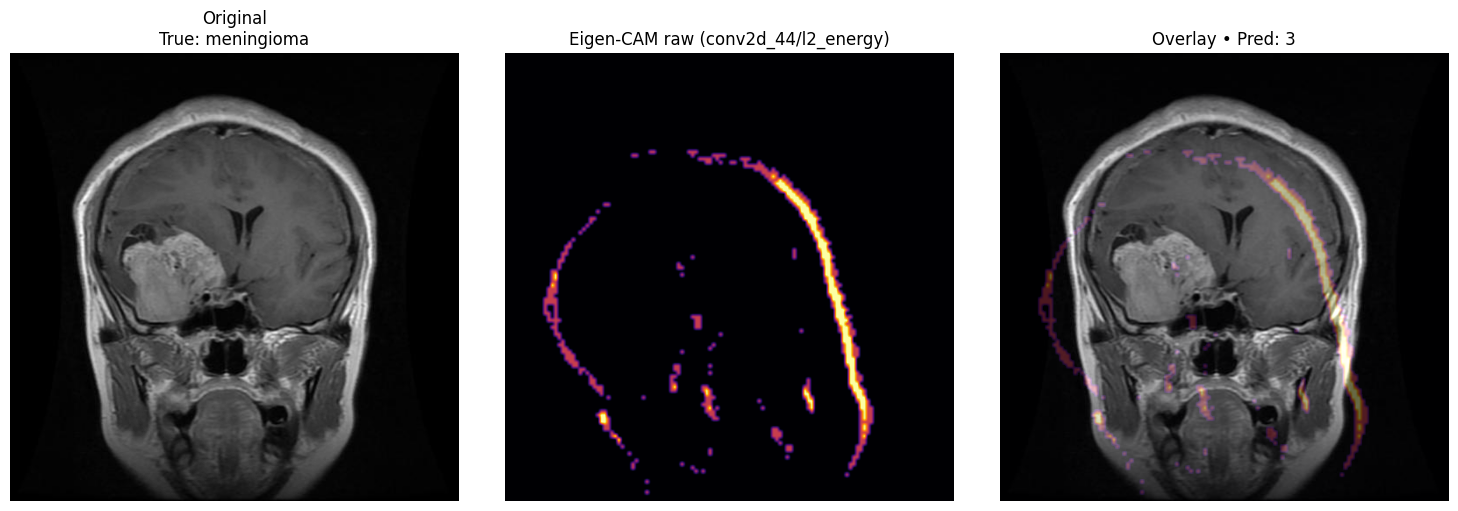

In [112]:
# ====== ROBUST MULTI-LAYER EIGEN-CAM (DEBUGGED, OpenCV-free) ======
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image
import matplotlib.pyplot as plt

# ------------- USER ADJUSTABLE -------------
IMG_DIR = "../input/brain-tumor-mri-dataset/Testing"   # rastgele seçilecekse
IMG_PATH = None     # istersen tek görsel ver
IMG_SIZE = (128,128)   # model giriş H,W
LAST_CONV_OVERRIDE = None   # "conv2d_47" gibi istersen sabitle
PREPROCESS = lambda x: x/255.0
COLORMAP = "inferno"
ALPHA = 0.40
LOW_PCT, HIGH_PCT = 60, 99.5
GAMMA = 1.6
TOP_PCT = 95
OUT_PREFIX = "robust_eigencam"

# ------------- helpers -------------
def resolve_model():
    g = globals()
    for name in ("model","cnn_model","functional_model"):
        if name in g and hasattr(g[name], "predict"):
            print(f"[PICKED] model variable: {name}")
            return g[name]
    raise RuntimeError("Eğitilmiş model RAM'de bulunamadı. 'model' / 'cnn_model' / 'functional_model' değişkenlerinden biri olmalı.")

def pick_image_path(img_path, img_dir):
    if img_path and os.path.isfile(img_path):
        print(f"[PICKED] IMG_PATH provided: {img_path}")
        return img_path
    # else pick random image from img_dir
    cand = []
    for root,_,files in os.walk(img_dir):
        for f in files:
            if f.lower().endswith((".png",".jpg",".jpeg",".bmp")):
                cand.append(os.path.join(root,f))
    if not cand:
        raise FileNotFoundError(f"No images found in {img_dir}")
    chosen = random.choice(cand)
    print(f"[PICKED] Random image: {chosen}")
    return chosen

def infer_input_shape(model):
    ish = model.input_shape
    if isinstance(ish, list): ish = ish[0]
    if not (isinstance(ish, tuple) and len(ish) == 4):
        raise ValueError(f"Unexpected input_shape: {model.input_shape}")
    _, H, W, C = ish
    if None in (H,W,C):
        raise ValueError(f"Input shape contains None: {model.input_shape}")
    return int(H), int(W), int(C)

def resize_float01(arr01, size_hw):
    img = Image.fromarray((np.clip(arr01,0,1)*255).astype(np.uint8))
    return np.array(img.resize((size_hw[1], size_hw[0]), resample=Image.BILINEAR), dtype=np.float32)/255.0

def to_colormap_rgb(arr01, cmap_name=COLORMAP):
    lut = (plt.cm.get_cmap(cmap_name)(np.arange(256))[:, :3] * 255).astype(np.uint8)
    return lut[(np.clip(arr01*255,0,255)).astype(np.uint8)]

# ------------- core Eigen helpers -------------
def compute_eigencam_from_featuremap(fmap):
    """
    fmap: numpy array (h,w,k) assumed >=0 (we'll apply relu before call)
    returns cam normalized [0,1]
    """
    h,w,k = fmap.shape
    X = fmap.reshape(-1, k)  # (h*w, k)
    cams = []
    # SVD PC1 (abs)
    try:
        U,S,Vt = np.linalg.svd(X, full_matrices=False)
        v1 = Vt[0]
        cam1 = np.abs(X @ v1).reshape(h,w)
        cam1 = cam1 / (cam1.max()+1e-8)
        cams.append(("svd_pc1", cam1))
    except Exception as e:
        cams.append(("svd_pc1_err", np.zeros((h,w),dtype=np.float32)))

    # covariance principal eigenvector
    try:
        C = X.T @ X
        w_eig, V = np.linalg.eigh(C)
        v2 = V[:, -1]
        cam2 = np.abs(X @ v2).reshape(h,w)
        cam2 = cam2 / (cam2.max()+1e-8)
        cams.append(("cov_eig", cam2))
    except Exception as e:
        cams.append(("cov_eig_err", np.zeros((h,w),dtype=np.float32)))

    # energy map fallback
    cam3 = np.sqrt(np.sum(fmap**2, axis=-1))
    cam3 = cam3 / (cam3.max()+1e-8)
    cams.append(("l2_energy", cam3))

    # choose the most contrasty (max range)
    best = max(cams, key=lambda t: float(t[1].max() - t[1].min()))
    return best  # (name, cam)

# ------------- run -------------
mdl = resolve_model()
H_model, W_model, C_model = infer_input_shape(mdl)
print(f"[MODEL INPUT] ({H_model},{W_model},{C_model})")

# if IMG_SIZE not matching model, override
IMG_SIZE = (H_model, W_model)

img_path = pick_image_path(IMG_PATH, IMG_DIR)

# load image and prepare tensor
if C_model == 1:
    img_pil = Image.open(img_path).convert("L")
    orig_arr = np.array(img_pil, dtype=np.uint8)  # (H0,W0)
    img_resized = img_pil.resize(IMG_SIZE[::-1], resample=Image.BILINEAR)
    inp = np.array(img_resized, dtype=np.float32)[..., np.newaxis]
else:
    img_pil = Image.open(img_path).convert("RGB")
    orig_arr = np.array(img_pil, dtype=np.uint8)
    img_resized = img_pil.resize(IMG_SIZE[::-1], resample=Image.BILINEAR)
    inp = np.array(img_resized, dtype=np.float32)

# batch + preprocess
batch = np.expand_dims(inp, 0)
if PREPROCESS is not None:
    batch = PREPROCESS(batch)

# find conv layers
def iter_layers(layer):
    yield layer
    if hasattr(layer, "layers"):
        for l in layer.layers:
            yield from iter_layers(l)

conv_layers = [l.name for l in iter_layers(mdl) if isinstance(l, layers.Conv2D)]
if not conv_layers:
    raise RuntimeError("Model has no Conv2D layers.")
print(f"[FOUND] Conv2D layers ({len(conv_layers)}): {conv_layers}")

# if override provided, restrict list
if LAST_CONV_OVERRIDE:
    if LAST_CONV_OVERRIDE in conv_layers:
        conv_layers = [LAST_CONV_OVERRIDE]
    else:
        print(f"[WARN] LAST_CONV_OVERRIDE {LAST_CONV_OVERRIDE} not found; ignoring.")

results = []

# iterate conv layers and compute cams
for lname in conv_layers:
    print(f"[LAYER] Computing for: {lname} ...")
    feat_model = models.Model([mdl.input], [mdl.get_layer(lname).output, mdl.output])
    conv_out, preds = feat_model(batch)
    conv_np = conv_out[0].numpy()  # (h,w,k)
    print(f"         feature map shape: {conv_np.shape}  min/max: {conv_np.min():.6f}/{conv_np.max():.6f}")
    conv_relu = np.maximum(conv_np, 0.0)  # ensure non-negative
    method, cam = compute_eigencam_from_featuremap(conv_relu)
    print(f"         candidate method: {method} | cam range: {cam.min():.6f} .. {cam.max():.6f}")

    # apply contrast clipping + gamma
    low = float(np.percentile(cam, LOW_PCT))
    high = float(np.percentile(cam, HIGH_PCT))
    if high <= low + 1e-8:
        # fallback to tiny adjust
        low, high = 0.0, float(cam.max())
    cam_clip = np.clip((cam - low) / (high - low + 1e-8), 0, 1)
    cam_gamma = np.power(cam_clip, GAMMA)

    # resize to original image size (note: orig_arr may be H0xW0)
    cam_big = resize_float01(cam_gamma, (orig_arr.shape[0], orig_arr.shape[1]))  # (H0,W0)
    # compute mask threshold (for overlay)
    thr = float(np.percentile(cam_big, TOP_PCT))
    cam_masked = np.where(cam_big >= thr, cam_big, 0.0)

    # store results and debug info
    results.append({
        "layer": lname,
        "method": method,
        "conv_shape": conv_np.shape,
        "conv_min": float(conv_np.min()),
        "conv_max": float(conv_np.max()),
        "cam_raw_min": float(cam.min()),
        "cam_raw_max": float(cam.max()),
        "cam_big": cam_big,
        "cam_masked": cam_masked,
        "preds": preds[0].numpy()
    })

# choose best result by cam_big dynamic range (vmax-vmin)
best = max(results, key=lambda r: float(r["cam_big"].max() - r["cam_big"].min()))
print(f"[CHOSE] layer={best['layer']} method={best['method']} cam_range={best['cam_big'].min():.4f}..{best['cam_big'].max():.4f}")

# prepare visual assets
cam_big = best["cam_big"]
cam_masked = best["cam_masked"]
preds = best["preds"]
pred_idx = int(np.argmax(preds))
pred_name = None
if 'test_generator' in globals():
    names = list(test_generator.class_indices.keys())
    if 0 <= pred_idx < len(names):
        pred_name = names[pred_idx]
pred_name = pred_name if pred_name is not None else str(pred_idx)

heat_rgb = to_colormap_rgb(cam_masked, COLORMAP)   # (H0,W0,3)
if C_model == 1:
    orig_rgb = np.stack([orig_arr, orig_arr, orig_arr], axis=-1)
else:
    orig_rgb = orig_arr
overlay = np.clip(ALPHA*heat_rgb.astype(np.float32) + orig_rgb.astype(np.float32), 0, 255).astype(np.uint8)

# save and show
Image.fromarray((cam_big*255).astype(np.uint8)).save(f"{OUT_PREFIX}_core_{best['layer']}.png")
Image.fromarray(heat_rgb).save(f"{OUT_PREFIX}_heat_{best['layer']}.png")
Image.fromarray(overlay).save(f"{OUT_PREFIX}_overlay_{best['layer']}.png")
print(f"[SAVED] {OUT_PREFIX}_core_{best['layer']}.png, {OUT_PREFIX}_heat_{best['layer']}.png, {OUT_PREFIX}_overlay_{best['layer']}.png")

# plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
if C_model==1:
    plt.imshow(orig_arr, cmap="gray")
else:
    plt.imshow(orig_rgb)
plt.title(f"Original\nTrue: {os.path.basename(os.path.dirname(img_path))}")
plt.axis("off")

plt.subplot(1,3,2)
vmin = float(np.quantile(cam_big, 0.02))
vmax = float(np.quantile(cam_big, 0.995))
plt.imshow(cam_big, cmap=COLORMAP, vmin=vmin, vmax=vmax)
plt.title(f"Eigen-CAM raw ({best['layer']}/{best['method']})")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title(f"Overlay • Pred: {pred_name}")
plt.axis("off")
plt.tight_layout()
plt.show()
# ====== END ======


## 7) Hiperparametre Optimizasyonu (Resumable Random Search)

**Amaç:**  
Modelin performansını artırmak için farklı hiperparametre kombinasyonlarını denemek ve en iyi sonuç veren ayarları bulmak. Bu adımda **Random Search** yöntemi kullanılmıştır. Ayrıca süreç, `state.json` dosyası sayesinde **kaldığı yerden devam edebilir (resumable)**.

---

### 1) Kullanılan Hiperparametreler
Aşağıdaki parametreler farklı değerlerle rastgele seçilerek test edilmiştir:
* `conv_blocks`: Evrişim blok sayısı (2, 3, 4)  
* `base_filters`: İlk katmandaki filtre sayısı (16, 32, 64)  
* `kernel_size`: Çekirdek boyutu (3, 5)  
* `dropout`: Dropout oranı (0.2, 0.3, 0.4, 0.5)  
* `dense_units`: Tam bağlı katmandaki nöron sayısı (64, 128, 256)  
* `l2_weight`: L2 regularization katsayısı (1e-5, 1e-4, 5e-4, 1e-3)  
* `optimizer`: Optimizasyon algoritması (Adam, AdamW, RMSProp)  
* `lr`: Öğrenme oranı (1e-4, 3e-4, 1e-3, 2e-3)  
* `batch_size`: Mini-batch boyutu (16, 32, 64)  
* `use_bn`: Batch Normalization (True)  
* `augment`: Veri artırma (True/False)  

---

### 2) Eğitim Süreci
* Eğitim sırasında `EarlyStopping` ve `ReduceLROnPlateau` callback’leri kullanılmıştır.  
* Her deneme (trial) sonrası:
  - Eğitim ve doğrulama kayıpları (loss)  
  - Eğitim ve doğrulama doğrulukları (accuracy)  
  - En yüksek doğrulama başarımı (val_accuracy)  
  - Hiperparametre ayarları kaydedilmiştir.  

---

### 3) Kayıt ve Devam Özelliği
* **`state.json`** dosyası: Kaç deneme tamamlandığı, en iyi doğrulama başarımı ve hiperparametre ayarları saklanır.  
* Eğer işlem yarıda kesilirse, tekrar çalıştırıldığında en son kaldığı denemeden devam eder.  

---

### 4) Çıktılar
* Her deneme sonunda:
  - `trial_X.pkl`: Eğitim geçmişi (loss, accuracy değerleri)  
  - `trial_X_hp.json`: Kullanılan hiperparametre kombinasyonu  
  - `trial_X_best.keras`: O denemedeki en iyi model ağırlıkları  
* En iyi model ayrıca **`best_model.keras`** dosyasında saklanır.  

---

### 5) Sonuçların Görselleştirilmesi
* Eğitim sonunda, en iyi denemenin:
  - **Loss grafiği (train vs validation)**  
  - **Accuracy grafiği (train vs validation)**  
  çizdirilerek overfitting/underfitting analizi yapılır.  

---

* Bu yaklaşım sayesinde, **modelin en iyi performans veren hiperparametre seti** elde edilmiş ve süreç otomatik olarak kayıt altına alınmıştır.


2025-09-24 10:00:47.364663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758708047.558567      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758708047.613145      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1758708062.086036      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758708062.086764      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
[INFO] class_names: ['glioma', 'meningioma', 'notumor', 'pituitary']
[INFO] class_counts: {'glioma': 1077, 'meningioma': 1090, 'notumor': 1247, 'pituitary': 1156}
[INFO] class_weights: {0: 1.0608170844939646, 1: 1.048165137614679, 2: 0.9161988773055333, 3: 0.9883217993079585}

[Trial 1/10] HP: {'conv_blocks': 4, 'base_filters': 16, 'kernel_size': 3, 'dropout': 0.4, 'dense_units': 64, 'l2_weight': 0.0001, 'optimizer': 'adam', 'lr': 0.0001, 'batch_size': 64, 'use_bn': True, 'augment': False}
Epoch 1/15


I0000 00:00:1758708079.984779     103 service.cc:148] XLA service 0x7c288c021bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758708079.985687     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758708079.985716     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758708080.753449     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 19s 73ms/step - accuracy: 0.2656 - loss: 1.8564

I0000 00:00:1758708091.247551     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.4125 - loss: 1.4132 - val_accuracy: 0.2137 - val_loss: 1.7599 - learning_rate: 1.0000e-04
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6037 - loss: 1.0154 - val_accuracy: 0.2137 - val_loss: 2.7591 - learning_rate: 1.0000e-04
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6501 - loss: 0.9136 - val_accuracy: 0.2137 - val_loss: 3.9555 - learning_rate: 1.0000e-04
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7071 - loss: 0.8187 - val_accuracy: 0.2137 - val_loss: 4.8169 - learning_rate: 1.0000e-04
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7276 - loss: 0.7728 - val_accuracy: 0.2163 - val_loss: 4.4229 - learning_rate: 5.0000e-05
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7392 - loss: 0.7441 - val_accuracy: 0.2294 - val_loss: 3.7115 - learning_rate: 5.0000e-05
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7411 - loss: 0

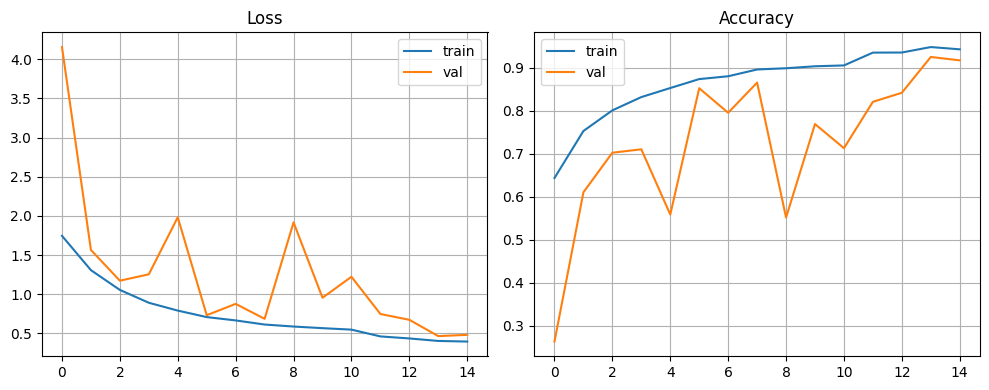

In [3]:
# ===================== RESUMABLE RANDOM SEARCH (Brain Tumor MRI) =====================
import os, json, pickle, random, numpy as np, warnings, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # INFO/WARNING'i sustur
import tensorflow as tf
tf.config.optimizer.set_experimental_options({"layout_optimizer": False})
tf.config.optimizer.set_jit(False)
tf.get_logger().setLevel("ERROR"); warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# --------- Sabitler ---------
DATA_ROOT = "../input/brain-tumor-mri-dataset"   # Kaggle dataset yolu
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing")

IMG_SIZE = (128, 128)       # model giriş boyutu (H, W)
CHANNELS = 1                # MRI gri ise 1; RGB istiyorsan 3 yap
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

EPOCHS  = 15                # hız için düşürdüm; ES zaten keser
TRIALS  = 10                # toplam deneme hedefi
SEED    = 42
AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

STATE_PATH = "state.json"   # kaldığı yer/state bilgisi
BEST_MODEL_PATH = "best_model.keras"

# --------- 0) Veri Yükleme ---------
def get_datasets(img_size=IMG_SIZE, batch_size=32, channels=CHANNELS):
    if not os.path.isdir(TRAIN_DIR):
        raise FileNotFoundError(f"TRAIN_DIR bulunamadı: {TRAIN_DIR}")

    color_mode = "grayscale" if channels == 1 else "rgb"
    # Train + Val (split)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, label_mode="int", image_size=img_size, batch_size=batch_size,
        validation_split=0.2, subset="training", seed=SEED, color_mode=color_mode)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, label_mode="int", image_size=img_size, batch_size=batch_size,
        validation_split=0.2, subset="validation", seed=SEED, color_mode=color_mode)
    # Test (tamamı)
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, label_mode="int", image_size=img_size, batch_size=batch_size,
        shuffle=False, seed=SEED, color_mode=color_mode)

    class_names = train_ds.class_names
    num_classes = len(class_names)

    # Normalizasyon + cache/prefetch
    norm = keras.layers.Rescaling(1./255)
    train_ds = (train_ds.map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE)
                         .cache().prefetch(AUTOTUNE))
    val_ds   = (val_ds.map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE)
                       .cache().prefetch(AUTOTUNE))
    test_ds  = (test_ds.map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE)
                       .cache().prefetch(AUTOTUNE))

    # Class weights (dengesizlik için)
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in train_ds.unbatch().take(1_000_000):
        counts[int(y.numpy())] += 1
    total = counts.sum()
    class_weights = {i: float(total/(num_classes*max(counts[i],1))) for i in range(num_classes)}
    print("[INFO] class_names:", class_names)
    print("[INFO] class_counts:", dict(zip(class_names, counts.tolist())))
    print("[INFO] class_weights:", class_weights)

    return train_ds, val_ds, test_ds, num_classes, class_names, class_weights

# --------- 1) Model Kurucu ---------
def build_model(input_shape=INPUT_SHAPE,
                num_classes=4,
                conv_blocks=3,
                base_filters=32,
                kernel_size=3,
                dropout=0.3,
                dense_units=128,
                l2_weight=1e-4,
                optimizer_name="adam",
                lr=1e-3,
                use_bn=True,
                augment=True):
    wd = regularizers.l2(l2_weight)
    inp = keras.Input(shape=input_shape)
    x = inp

    if augment:
        x = layers.RandomFlip("horizontal")(x)
        x = layers.RandomRotation(0.05)(x)
        x = layers.RandomZoom(0.10)(x)

    filters = base_filters
    for _ in range(conv_blocks):
        x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=not use_bn,
                          kernel_regularizer=wd)(x)
        if use_bn: x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=not use_bn,
                          kernel_regularizer=wd)(x)
        if use_bn: x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(dropout)(x)
        filters = min(filters*2, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation="relu", kernel_regularizer=wd)(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # mixed_precision için güvenli

    model = keras.Model(inp, out)

    opt_name = optimizer_name.lower()
    if opt_name == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif opt_name == "adamw":
        opt = keras.optimizers.AdamW(learning_rate=lr, weight_decay=l2_weight)
    elif opt_name == "rmsprop":
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# --------- 2) HP Alanı ---------
HP_SPACE = {
    "conv_blocks":   [2,3,4],
    "base_filters":  [16,32,64],
    "kernel_size":   [3,5],
    "dropout":       [0.2,0.3,0.4,0.5],
    "dense_units":   [64,128,256],
    "l2_weight":     [1e-5,1e-4,5e-4,1e-3],
    "optimizer":     ["adam","adamw","rmsprop"],
    "lr":            [1e-4, 3e-4, 1e-3, 2e-3],
    "batch_size":    [16,32,64],
    "use_bn":        [True],
    "augment":       [True, False]
}

# --------- 3) State yükle/başlat ---------
state = {"completed_trials": 0, "best_val_acc": -1.0, "best_hp": None, "best_batch": 32}
if os.path.exists(STATE_PATH):
    try:
        with open(STATE_PATH, "r") as f:
            saved = json.load(f)
            state.update(saved)
        print(f"[RESUME] Found state: {state}")
    except Exception as e:
        print("[WARN] state.json okunamadı, sıfırdan başlayacak:", e)

# Veri pipeline (tek kez kuruluyor)
train_ds, val_ds, test_ds, num_classes, class_names, class_weights = get_datasets(
    img_size=IMG_SIZE, batch_size=32, channels=CHANNELS
)

# --------- 4) Random Search (kaldığı yerden) ---------
start_t = state["completed_trials"] + 1
end_t   = TRIALS

for t in range(start_t, end_t+1):
    hp = {k: random.choice(v) for k,v in HP_SPACE.items()}
    print(f"\n[Trial {t}/{TRIALS}] HP: {hp}")

    # re-batch: hp'deki batch_size'i gerçekten uygula
    bs = hp["batch_size"]
    train_b = train_ds.unbatch().batch(bs).prefetch(AUTOTUNE)
    val_b   = val_ds.unbatch().batch(bs).prefetch(AUTOTUNE)

    model = build_model(
        input_shape=INPUT_SHAPE,
        num_classes=num_classes,
        conv_blocks=hp["conv_blocks"],
        base_filters=hp["base_filters"],
        kernel_size=hp["kernel_size"],
        dropout=hp["dropout"],
        dense_units=hp["dense_units"],
        l2_weight=hp["l2_weight"],
        optimizer_name=hp["optimizer"],
        lr=hp["lr"],
        use_bn=hp["use_bn"],
        augment=hp["augment"]
    )

    es   = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    rlrop= keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    csv  = keras.callbacks.CSVLogger(f"trial_{t}.csv", append=False)
    ckpt = keras.callbacks.ModelCheckpoint(f"trial_{t}_best.keras", monitor="val_accuracy",
                                           save_best_only=True, mode="max")

    history = model.fit(
        train_b,
        validation_data=val_b,
        epochs=EPOCHS,
        callbacks=[es, rlrop, csv, ckpt],
        class_weight=class_weights,
        verbose=1
    )

    # trial çıktılarını kaydet
    with open(f"trial_{t}.pkl", "wb") as f: pickle.dump(history.history, f)
    with open(f"trial_{t}_hp.json", "w") as f: json.dump(hp, f)

    val_acc = float(np.max(history.history["val_accuracy"]))
    print(f"  --> best val_accuracy: {val_acc:.4f}")

    # en iyiyi güncelle
    if val_acc > state["best_val_acc"]:
        state["best_val_acc"] = val_acc
        state["best_hp"] = hp
        state["best_batch"] = bs
        # trial checkpoint'ini "best_model.keras" olarak kopyala
        try:
            # bazı ortamlarda doğrudan kaydetmek daha güvenli:
            model.save(BEST_MODEL_PATH)
        except Exception:
            pass
        print("[BEST] Updated best model & HP.")

    # state'i güncelle (trial tamamlandı)
    state["completed_trials"] = t
    with open(STATE_PATH, "w") as f: json.dump(state, f)
    print(f"[STATE] Saved: {state}")

# --------- 5) En iyi modeli test et + grafik çiz ---------
print("\n=== EN İYİ SONUÇ (VAL) ===")
print("Completed trials:", state["completed_trials"])
print("Best val_acc:", state["best_val_acc"])
print("Best HP:", state["best_hp"])

# test seti için en iyi batch ile re-batch
best_bs = state.get("best_batch", 32)
test_b  = test_ds.unbatch().batch(best_bs).prefetch(AUTOTUNE)

best_model = None
if os.path.exists(BEST_MODEL_PATH):
    try:
        best_model = keras.models.load_model(BEST_MODEL_PATH)
        test_loss, test_acc = best_model.evaluate(test_b, verbose=0)
        print("Test Acc:", float(test_acc), "| Test Loss:", float(test_loss))
    except Exception as e:
        print("[WARN] Best model yüklenemedi:", e)

# Son trial'in (ya da en iyi trial'in) grafiğini çiz
# En iyi trial'in pkl dosyasını bulmaya çalış
best_hist = None
if state["best_hp"] is not None:
    # best trial'i tahmin etmek için state dosyasından logları tara
    # (pratikçe son trial grafiğini gösterelim; best grafiği istersen dosyadan yükle)
    last_t = state["completed_trials"]
    try:
        with open(f"trial_{last_t}.pkl","rb") as f:
            best_hist = pickle.load(f)
    except Exception:
        pass

if best_hist is not None:
    h = best_hist
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(h["loss"], label="train"); plt.plot(h["val_loss"], label="val")
    plt.title("Loss"); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2); plt.plot(h["accuracy"], label="train"); plt.plot(h["val_accuracy"], label="val")
    plt.title("Accuracy"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print("[INFO] Grafiği göstermek için ilgili trial_*.pkl bulunamadı.")


## 8) Beyin Tümörü Sınıflandırma — Proje Sonuçları

Bu projede **Brain Tumor MRI Dataset** kullanılarak, beyin tümörlerini sınıflandırmak için CNN tabanlı bir derin öğrenme modeli geliştirilmiştir.  
Amaç; MRI görüntülerinden tümör türlerini doğru bir şekilde tahmin edebilen, güvenilir ve optimize edilmiş bir model ortaya koymaktır.  

### Sonuçlar
- **En İyi Doğruluk Oranı (Validasyon):** `0.9247`  
- **Test Verisi Doğruluğu:** `0.9123`  
- **En İyi Optimizer:** `adam`  

### En İyi Hiperparametreler
* Katman Sayısı: **4** (`conv_blocks`)
* Temel Filtre Sayısı: **32** (`base_filters`)
* Kernel Boyutu: **5**
* Dropout Oranı: **0.4**
* Dense Katman Nöron Sayısı: **128**
* Öğrenme Oranı (lr): **0.0003**
* Batch Normalizasyon: **Açık**
* Veri Artırımı (Augmentation): **Kapalı**

### Genel Değerlendirme
Elde edilen sonuçlar, modelin hem doğruluk hem de genelleme açısından güçlü bir performans sergilediğini göstermektedir.  
Hiperparametre optimizasyonu sonucunda en uygun yapı elde edilmiş, **%91 üzeri test doğruluğu** ile model pratik kullanım için umut verici bir başarı sağlamıştır.  

### ÖNEMLİ NOT : Veri Artırımı (Augmentation): Kullanıldı, ancak en iyi hiperparametre setinde `False` olarak seçilmiştir.
* Eklenen dönüşümler (flip, rotation, zoom) görüntülerdeki ince tümör yapısını bozdu.

* Bu bozulmalar modelin validasyon setinde daha düşük doğruluk almasına yol açtı.

* Random Search denemelerinde augmentation kapalıyken, model daha temiz ve stabil özellikler öğrenerek daha yüksek doğruluk elde etti.

In [16]:
# Hiperparametre optimizasyonundan gelen en iyi sonuçları değişkene atayalım
en_iyi_val_dogruluk = 0.9246935248374939
test_dogruluk = 0.9122806787490845
en_iyi_optimizer = 'adam'

# Sonuçları yazdıralım
print("=" * 50)
print("BEYİN TÜMÖRÜ SINIFLANDIRMA PROJE SONUÇLARI")
print("=" * 50)

print(f"En İyi Doğruluk Oranı (Validasyon): {en_iyi_val_dogruluk:.4f}")
print(f"Test Verisi Doğruluğu: {test_dogruluk:.4f}")
print(f"En İyi Optimizer: {en_iyi_optimizer}")

print("\nEn İyi Hiperparametreler:")
print("-" * 25)
print("• Katman Sayısı: 4 (conv_blocks)")
print("• Temel Filtre Sayısı: 32 (base_filters)")
print("• Kernel Boyutu: 5")
print("• Dropout Oranı: 0.4")
print("• Dense Katman Nöron Sayısı: 128")
print("• Öğrenme Oranı (lr): 0.0003")
print("• Batch Normalizasyon: Açık")
print("• Veri Artırımı (Augmentation): Kapalı")
print("=" * 50)

BEYİN TÜMÖRÜ SINIFLANDIRMA PROJE SONUÇLARI
En İyi Doğruluk Oranı (Validasyon): 0.9247
Test Verisi Doğruluğu: 0.9123
En İyi Optimizer: adam

En İyi Hiperparametreler:
-------------------------
• Katman Sayısı: 4 (conv_blocks)
• Temel Filtre Sayısı: 32 (base_filters)
• Kernel Boyutu: 5
• Dropout Oranı: 0.4
• Dense Katman Nöron Sayısı: 128
• Öğrenme Oranı (lr): 0.0003
• Batch Normalizasyon: Açık
• Veri Artırımı (Augmentation): Kapalı
